In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!mkdir notebook
%cd notebook

mkdir: cannot create directory ‘notebook’: File exists
/content/notebook


In [6]:
!pwd

/content/notebook


In [7]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip -P /content/notebook

--2020-04-04 09:26:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘/content/notebook/Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  34.0MB/s    in 73s     

2020-04-04 09:27:54 (33.8 MB/s) - ‘/content/notebook/Positive_tensors.zip’ saved [2598656062/2598656062]



In [0]:
!unzip -q Positive_tensors.zip -d /content/notebook

In [9]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip -P /content/notebook

--2020-04-04 09:34:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘/content/notebook/Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  33.7MB/s    in 60s     

2020-04-04 09:35:12 (33.7 MB/s) - ‘/content/notebook/Negative_tensors.zip’ saved [2111408108/2111408108]



In [0]:
!unzip -q Negative_tensors.zip -d /content/notebook

In [13]:
import os
data_path = "/content/notebook/"
output_dir = data_path + "/Positive_tensors"
if os.path.exists(output_dir):
    print("Number of files in directory '{}' : {}".format(output_dir, len([name for name in os.listdir(output_dir)])))

output_dir = data_path + "/Negative_tensors"
if os.path.exists(output_dir):
    print("Number of files in directory '{}' : {}".format(output_dir, len([name for name in os.listdir(output_dir)])))

Number of files in directory '/content/notebook//Positive_tensors' : 20000
Number of files in directory '/content/notebook//Negative_tensors' : 20000


In [14]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [0]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

In [16]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=data_path 
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [17]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [18]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
        param.requires_grad=False

In [0]:
model.fc=nn.Linear(512,2)

In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [0]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [0]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    loss_sublist=[]
    for x, y in train_loader:

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        
        #make a prediction 
        z = model(x)
   
        # calculate loss 
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        # calculate gradients of parameters
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        loss_list.append(np.mean(loss_sublist))
    
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval
        model.eval()
       
        #make a prediction
        z = model(x_test)
        
        #find max
        _, yhat = torch.max(z.data, 1)
       
        #Calculate misclassified  samples in mini-batch 
        correct +=(yhat==y_test).sum().item()
        
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

In [26]:
accuracy

0.9945

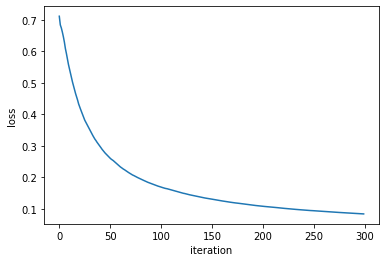

In [27]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [29]:
count = 0
maxitems = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; predicted value: {}; actual value: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= maxitems:
            break
    # end if
# end for   

Sample : 179; predicted value: tensor([0]); actual value: tensor([1])
Sample : 258; predicted value: tensor([1]); actual value: tensor([0])
Sample : 527; predicted value: tensor([0]); actual value: tensor([1])
Sample : 538; predicted value: tensor([1]); actual value: tensor([0])
